# Assignment 2: Python for Text Processing

**Submission deadline:** Friday, 31 Oct 2025, 11:55 PM  
**Assessment marks:** 35 marks (35% of the total unit assessment)

---

### Late Submission Penalty

Unless a Special Consideration request has been submitted and approved, a 5% penalty (of the total possible mark of the task) will be applied for each day a written report or presentation assessment is not submitted, up until the 7th day (including weekends). After the 7th day, a grade of ‘0’ will be awarded even if the assessment is submitted.

> **Example:** If the assignment is worth 8 marks (of the entire unit) and your submission is late by 19 hours (or 23 hours 59 minutes 59 seconds), 0.4 marks (5% of 8 marks) will be deducted. If your submission is late by 24 hours (or 47 hours 59 minutes 59 seconds), 0.8 marks (10% of 8 marks) will be deducted, and so on.

The submission time for all uploaded assessments is **11:55 PM**. A **1-hour grace period** is provided for technical concerns.  Apply for [Special Consideration](https://students.mq.edu.au/study/assessment-exams/special-consideration), if you think you should be granted an extended deadline or waive the late submission penalty. You should apply immediately when the situation occurs.

---

### Academic Integrity

All submitted work must be your own. For rules around AI tools, refer to **"Using Generative AI Tools" on iLearn**.

---

## Instructions

* Complete the five tasks below.

* Write your code and comments inside this notebook.

* Your notebook must include the running outputs of your final code.

* **Submit this `.ipynb` file, containing your code and outputs, to iLearn.**

---

### Assessment

-  Marks are based on the correctness of your code, outputs, and coding style.
-  A total of **2.5 marks** (0.5 per task) are awarded globally across the assignment for both of the below: (1) runnable codes; (2) good coding style: clean, modular code, meaningful variable names, and good comments.
-  If outputs are missing or incorrect, up to **25% of the marks for that task** can be deducted.
-  See each task below for the detailed mark breakdown.

---

### AI Tools Usage Policy


In this assignment, we view AI code generators such as copilot, CodeGPT, etc as tools that can help you write code quickly. You are allowed to use these tools, but with some conditions. To understand what you can and what you cannot do, please visit these information pages provided by Macquarie University.

- See: [Artificial Intelligence Tools and Academic Integrity in FSE](https://bit.ly/3uxgQP4)

If you choose to use these tools, make the following explicit in your submitted file as comments starting with "Use of AI generators in this assignment" :

- What part of your code is based on the output of such tools,
- What tools you used,
- What prompts you used to generate the code or text, and
- What modifications you made on the generated code or text?

This will help us assess your work fairly. 

**If we observe that you have used an AI generator and you do not give the above information, you may face disciplinary action.**





## Objectives of this assignment

In this assignment, you will work on the Quora Question Pairs (QQP) datset detailed below. The first two tasks will help you get familiar with the data, and the remaining requires you to implement deep neural networks.


**About the Quora Question Pairs (QQP) Dataset**

Description: A large dataset of 400k+ question pairs from Quora, labeled whether they are duplicates (semantically the same) or not. It features informal, noisy text with class imbalance, hard positives (low lexical overlap) and hard negatives (high overlap, different meaning). QQP is practically relevant for deduplicating FAQs, search, and support systems. Working on QQP builds transferable skills, such as text preprocessing, model comparison, threshold tuning, error analysis, and deployment-minded reasoning about real applications.

**Get familiar with the dataset**

In [187]:
!pip -q install datasets    # Install the datasets package to access the dataset
# add the packages you used, and specify the verion you installed

# All required import for the assignment.
from datasets import load_dataset
import numpy as np
import nltk

from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from collections import Counter

from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [188]:
'''
Selecting the device to run the model on.
cuda - Nvidia GPU
mps - Apple M1 GPU
cpu - CPU of the device
'''
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")


print("The device is:", DEVICE)

The device is: mps


In [191]:
# Set random seeds for reproducibility
SEED = 7
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [192]:
# 1) Load QQP
ds = load_dataset("glue", "qqp")

# Use validation set as our test; optionally create a smaller train subset for speed
train_ds = ds["train"]
eval_ds  = ds["validation"]

q1_tr = list(train_ds["question1"])
q2_tr = list(train_ds["question2"])
y_tr  = np.array(train_ds["label"])

q1_te = list(eval_ds["question1"])
q2_te = list(eval_ds["question2"])
y_te  = np.array(eval_ds["label"])

### Task 1. What is the top-5 common NOUN in the question1 and question2, respectively? (5 marks)

Write codes that returns the top-5 common NOUN in the questions. To find the part of speech, use NLTK's "Universal" tag set. You may need to use NLTK's `sent_tokenize` and `word_tokenize` to get words. The function returns a list that is descendingly sorted according to freqency, e.g. [(noun1, 22), (noun2, 10), ...].
<!-- To produce the correct results, the function must do this.  -->
Hint: The following steps will produce the correct results:

- Concatenate all questions together.
- Use the NLTK libraries to find the tokens and the stems.
- Use NLTK's sentence tokeniser before NLTK's word tokeniser.
- Use NLTK's part of speech tagger, using the "Universal" tagset.
- Use NLTK's `pos_tag_sents` instead of `pos_tag`.

Marking Criteria: 
- 2.5 marks for the correct codes and results of each column, namely question1 and question2 columns.




In [197]:
def get_word_tokens(data):
    '''
    Tokenizes the input data into word tokens.
    Args:
        data (list): A list of strings to be tokenized.
    Returns:
        list: A list of lists, where each sublist contains word tokens of a sentence.

    Joins the list of sentences into a single string, then splits it into sentences,
    and finally tokenizes each sentence into words.
    '''
    sep = ' '
    joined_data = sep.join(data)
    wt = [nltk.word_tokenize(s) for s in nltk.sent_tokenize(joined_data)]
    return wt

In [198]:
# Stemming
stemmer = nltk.PorterStemmer()

def get_stems(word_tokens):
    '''
    Stems the word tokens using Porter Stemmer.
    Args:
        word_tokens (list): A list of lists, where each sublist contains word tokens of a sentence.
    Returns:
        list: A list of lists, where each sublist contains stemmed word tokens of a sentence.
    '''
    return [[stemmer.stem(token.lower()) for token in sentence] for sentence in word_tokens]


In [ ]:
def get_tagged_words(word_token):
    '''
    Tags the word tokens with their respective parts of speech using "universal" tagset.
    Args:
        word_token (list): A list of lists, where each sublist contains word tokens of a sentence.
    Returns:
        list: A list of lists, where each sublist contains tuples of word tokens and their POS tags.
    '''
    tagged_words_list = nltk.pos_tag_sents(word_token, tagset='universal')
    return tagged_words_list

In [200]:
def get_most_common_nouns(tagged_words_list, n_top=5):
    '''
    Finds the most common nouns in the tagged words list.
    Args:
        tagged_words_list (list): A list of lists, where each sublist contains tuples of word tokens and their POS tags.
        n_top (int): The number of most common nouns to return.
    Returns:
        list: A list of tuples, where each tuple contains a noun and its frequency.
    '''
    tagged_nouns = [
        stemmer.stem(tagged_word[0].lower())
        for tagged_words in tagged_words_list
        for tagged_word in tagged_words
        if tagged_word[1] == 'NOUN'
    ]
    noun_counter = Counter(tagged_nouns)
    return noun_counter.most_common(n_top)


In [201]:
q1_tr_word_token = get_word_tokens(q1_tr)
q2_tr_word_token = get_word_tokens(q2_tr)

q1_tr_stem_token = get_stems(q1_tr_word_token)
q2_tr_stem_token = get_stems(q2_tr_word_token)

In [202]:
q1_tr_tagged_words = get_tagged_words(q1_tr_word_token)
q2_tr_tagged_words = get_tagged_words(q2_tr_word_token)

In [203]:
most_common_nouns_in_q1 = get_most_common_nouns(q1_tr_tagged_words)
most_common_nouns_in_q2 = get_most_common_nouns(q2_tr_tagged_words)

print('Top 5 most common nouns in question1:', most_common_nouns_in_q1)
print('Top 5 most common nouns in question2:', most_common_nouns_in_q2)


Top 5 most common nouns in question1: [('india', 12708), ('peopl', 11507), ('way', 10598), ('differ', 8623), ('quora', 7678)]
Top 5 most common nouns in question2: [('india', 13491), ('peopl', 12281), ('way', 11900), ('quora', 7967), ('time', 7579)]


### Task 2. What are the top-5 common stem 2-grams and non-stem 2-grams for question1 and question2, respectively? (5 marks)

Write codes that returns the top-5 most frequent 2-grams (bigrams) of stemmed and non-stemmed tokens along with their normalized frequency from the question1 and question2 columns of the QQP dataset. The output should be in descending order of frequency, **with frequencies normalized by the total number of bigrams (rounded to 4 decimal places)**, e.g., `[(('what', 'is'), 0.0105), (('what', 'are'), 0.0053), ...]`.

<!-- To produce the correct results, the function must do this: -->

Hint: The following steps will produce the correct results:

- Concatenate all questions together.
- Use NLTK's sentence tokeniser before NLTK's word tokeniser.
- Use the NLTK libraries to find the tokens and the stems.
- Use NLTK's Porter stemmer to get the root words.
- Round normalized frequency to 4 precision after the decimal point.
- When computing bigrams, do not consider words that are in different sentences. For example, if we have this text: `Sentence 1. And sentence 2.` the bigrams are: `('Sentence','1'), ('1','.'), ('.','And'), ('And','sentence')`, etc. Note that the following would not be a valid bigram, since the punctuation mark and the word "And" are in different sentences: `('.','And')`.

Marking Criteria: 
- 2.5 marks for the correct codes and restuls of each column, namely question1 and question2 columns.

In [ ]:
def get_top_bigrams(token_sequences, top_n=5):
    '''
    Computes the top N most common bigrams from the token sequences.
    Args:
        token_sequences (list): A list of lists, where each sublist contains word tokens of a sentence.
        top_n (int): The number of most common bigrams to return.
    Returns:
        list: A list of tuples, where each tuple contains a bigram (as a tuple of two words) and its relative frequency.
    '''

    bigram_counts = Counter()
    total_bigrams = 0
    for sentence in token_sequences:
        if not sentence:
            continue
        normalized_tokens = [token.lower() for token in sentence]
        sentence_bigrams = list(nltk.bigrams(normalized_tokens))
        if not sentence_bigrams:
            continue
        bigram_counts.update(sentence_bigrams)
        total_bigrams += len(sentence_bigrams)
    if total_bigrams == 0:
        return []
    return [
        (bigram, round(count / total_bigrams, 4))
        for bigram, count in bigram_counts.most_common(top_n)
    ]


We reuse the cached token lists to compute stemmed and non-stemmed bigram statistics for each question column, then print them in descending order as required.


In [13]:
q1_top_bigrams = get_top_bigrams(q1_tr_word_token)
q1_top_stem_bigrams = get_top_bigrams(q1_tr_stem_token)
q2_top_bigrams = get_top_bigrams(q2_tr_word_token)
q2_top_stem_bigrams = get_top_bigrams(q2_tr_stem_token)

print('Question1 top-5 non-stem bigrams:', q1_top_bigrams)
print('Question1 top-5 stem bigrams:', q1_top_stem_bigrams)
print('Question2 top-5 non-stem bigrams:', q2_top_bigrams)
print('Question2 top-5 stem bigrams:', q2_top_stem_bigrams)


Question1 top-5 non-stem bigrams: [(('what', 'is'), 0.0128), (('is', 'the'), 0.0112), (('what', 'are'), 0.0102), (('how', 'do'), 0.0084), (('can', 'i'), 0.0067)]
Question1 top-5 stem bigrams: [(('what', 'is'), 0.0128), (('is', 'the'), 0.0112), (('what', 'are'), 0.0102), (('how', 'do'), 0.0084), (('can', 'i'), 0.0067)]
Question2 top-5 non-stem bigrams: [(('what', 'is'), 0.0123), (('is', 'the'), 0.0108), (('what', 'are'), 0.0098), (('how', 'do'), 0.0085), (('can', 'i'), 0.0068)]
Question2 top-5 stem bigrams: [(('what', 'is'), 0.0123), (('is', 'the'), 0.0108), (('what', 'are'), 0.0098), (('how', 'do'), 0.0085), (('can', 'i'), 0.0068)]


### Task 3. Naïve Bayes Classifier (5.5 marks)

The QQR dataset contains pairs of questions with labels indicating whether the two questions are semantically duplicate (1) or not (0).

1. Using a Bag-of-Words representation, train a Naïve Bayes classifier to predict duplicates. (2 marks)

1. Report accuracy, precision, and recall on the test set. (1.5 marks)

1. Inspect your confusion matrix. Identify one type of error (false positive or false negative) that dominates. Suggest a possible reason for this pattern based on the dataset. (2 mark)

To keep every model comparable and quick to run locally, we cap the QQP dataset to 1k training and 100 validation examples. The same slice is reused across Tasks 3-5 per the assignment instructions.


In [4]:
# From now on, you are allowed to use a subset of the dataset which requires less computing resources.
# Note that you have to use the same subset for the following coding tasks, which ensure fairness when comparing performance across different models.

Ntrain = 1000
Ntest = 100
ds = load_dataset("glue", "qqp")

# Use validation set as our test; optionally create a smaller train subset for speed
train_ds = ds["train"].select(range(Ntrain))
eval_ds  = ds["validation"].select(range(Ntest))

This block builds a bag-of-words representation for both questions, fits the Naïve Bayes classifier, and records the metrics we will later compare against neural models.


In [5]:
# Reuse the QQP validation slice as our fixed test set
q1_test = list(eval_ds['question1'])
q2_test = list(eval_ds['question2'])
y_test = np.array(eval_ds['label'])

# Use the entire training set for fitting
q1_train = list(train_ds['question1'])
q2_train = list(train_ds['question2'])
y_train = np.array(train_ds['label'])

vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))
vectorizer.fit(q1_train + q2_train)

X_train = hstack([
    vectorizer.transform(q1_train),
    vectorizer.transform(q2_train),
])
X_test = hstack([
    vectorizer.transform(q1_test),
    vectorizer.transform(q2_test),
])

clf = MultinomialNB()
clf.fit(X_train, y_train)

train_predictions = clf.predict(X_train)
nb_train_accuracy = accuracy_score(y_train, train_predictions)
test_predictions = clf.predict(X_test)

nb_vectorizer = vectorizer
nb_clf = clf
nb_preds = test_predictions

nb_accuracy = accuracy_score(y_test, test_predictions)
nb_precision = precision_score(y_test, test_predictions, zero_division=0)
nb_recall = recall_score(y_test, test_predictions, zero_division=0)
nb_confusion = confusion_matrix(y_test, test_predictions)

print(f"Training accuracy (Ntrain={Ntrain}): {nb_train_accuracy:.4f}")
print(f"Test accuracy: {nb_accuracy:.4f}")
print(f"Precision: {nb_precision:.4f}")
print(f"Recall: {nb_recall:.4f}")
print('Confusion matrix:', nb_confusion)

fp, fn = nb_confusion[0, 1], nb_confusion[1, 0]
if fn > fp:
    dominant_error = 'false negatives'
    explanation = 'Duplicates with different wording slip through the bag-of-words features.'
elif fp > fn:
    dominant_error = 'false positives'
    explanation = 'Different questions that share surface words are mistaken as duplicates.'
else:
    dominant_error = 'balanced'
    explanation = 'False positives and false negatives occur at similar rates.'

print(f"Dominant error type: {dominant_error} (FP={fp}, FN={fn}). {explanation}")


Training accuracy (Ntrain=1000): 0.9800
Test accuracy: 0.7400
Precision: 0.6250
Recall: 0.3333
Confusion matrix: [[64  6]
 [20 10]]
Dominant error type: false negatives (FP=6, FN=20). Duplicates with different wording slip through the bag-of-words features.


Visualising the confusion matrix helps explain whether false positives or false negatives dominate, addressing the error-analysis requirement for Task 3.


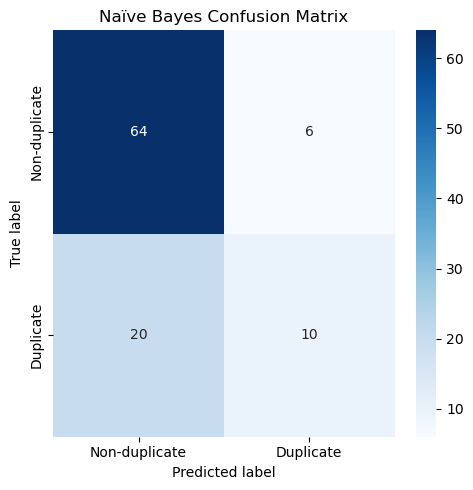

In [6]:
# Task 3: Visualise Naïve Bayes confusion matrix
plt.figure(figsize=(5, 5))
class_labels = ['Non-duplicate', 'Duplicate']
sns.heatmap(
    nb_confusion, annot=True, fmt='d', cmap='Blues',
    xticklabels=class_labels, yticklabels=class_labels
)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Naïve Bayes Confusion Matrix')
plt.tight_layout()
plt.show()


### Task 4. Siamese Neural Network (7 marks)

You now want to learn semantic similarity directly from the question pairs.

1. Design a Siamese Neural Network with two identical LSTM encoders that embed each question. (3 marks)

1. Use cosine similarity to classify duplicates, and report accuracy and F1-score. (2 marks)

1. Compare your Siamese model to your Naïve Bayes model. Which one handles imbalanced errors (precision vs. recall) better in your results, and why do you think that is? (2 marks)

For the Siamese network we set up a shared tokenizer and hyperparameters that mirror the practical, ensuring both question branches see consistent input lengths and embedding sizes.


In [158]:
from transformers import BertTokenizer

# --- Tokenizer ---
TOKENIZER_NAME = "bert-base-uncased"
TOKENIZER = BertTokenizer.from_pretrained(TOKENIZER_NAME)
VOCAB_SIZE = TOKENIZER.vocab_size
PAD_TOKEN_ID = TOKENIZER.pad_token_id

# --- parameters ---
MAX_LEN = 80
EMBED_SIZE = 256
LSTM_UNITS = 256
BATCH_SIZE = 25
N_EPOCHS = 5
LEARNING_RATE = 1e-3
MARGIN = 1.0
DROPOUT = 0.1

The custom dataset prepares paired tensors for each question. Packaging both questions together keeps the training loop simple and guarantees the Siamese encoders receive identical preprocessing.


In [134]:
class SiameseDataset(Dataset):
    # Dataset matches the practical: returns token ids and label per pair
    def __init__(self, sents1, sents2, labels, tokenizer, max_len):
        self.sents1 = sents1
        self.sents2 = sents2
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        q1_text = str(self.sents1[idx])
        q2_text = str(self.sents2[idx])
        label = self.labels[idx]

        encoded1 = self.tokenizer.encode_plus(
            q1_text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        encoded2 = self.tokenizer.encode_plus(
            q2_text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'ids1': encoded1['input_ids'].flatten(),
            'ids2': encoded2['input_ids'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float),
        }


Our Siamese model shares an embedding + LSTM encoder between the two questions, then scores their cosine similarity through a small classifier head to produce logits for duplicate prediction.


In [147]:
# Requirement 1: Siamese architecture with shared LSTM encoders
class SiameseNetwork(nn.Module):
    # Shared bidirectional LSTM encodes both questions with identical weights
    def __init__(self, vocab_size=VOCAB_SIZE, pad_idx=PAD_TOKEN_ID, embed_dim=EMBED_SIZE, hidden_size=LSTM_UNITS, dropout=DROPOUT):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_size, batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(dropout)

        self.classifier = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward_once(self, tokens):
        embedded = self.embedding(tokens)
        _, (hidden, _) = self.lstm(embedded)
        return self.dropout(hidden[0])
        

    def forward(self, q1, q2):
        h1 = self.forward_once(q1)
        h2 = self.forward_once(q2)
        cosine = F.cosine_similarity(h1, h2, dim=1).unsqueeze(-1)
        logits = self.classifier(cosine).squeeze(-1)
        return logits



Training and evaluation helpers encapsulate the optimisation loop. Keeping these utilities separate from the cell that instantiates the model keeps the notebook tidy and highlights the workflow steps.


In [136]:
def train_epoch(model, loader, optimiser, criterion, device):
    # End-to-end optimisation keeps gradients flowing into the shared encoder, unlike the two-stage practical
    model.train()
    total_loss = 0.0
    for batch in loader:
        ids1 = batch['ids1'].to(device)
        ids2 = batch['ids2'].to(device)
        labels = batch['labels'].float().to(device)

        optimiser.zero_grad()
        logits = model(ids1, ids2)
        loss = criterion(logits, labels)
        loss.backward()
        optimiser.step()
        total_loss += loss.item()
    return total_loss / len(loader)



In [137]:

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_probs, all_labels = [], []
    with torch.no_grad():
        # Evaluation converts logits to probabilities to compute threshold-based metrics
        for batch in loader:
            ids1 = batch['ids1'].to(device)
            ids2 = batch['ids2'].to(device)
            labels = batch['labels'].float().to(device)

            logits = model(ids1, ids2)
            loss = criterion(logits, labels)

            total_loss += loss.item()

            probs = torch.sigmoid(logits)

            
            all_probs.extend(probs.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    preds = (np.array(all_probs) >= 0.5).astype(float)
    labels_np = np.array(all_labels)

    print('preds === ', preds)
    print('lablessfasd === ', labels_np)

    accuracy = accuracy_score(labels_np, preds)
    precision = precision_score(labels_np, preds, zero_division=0)
    recall = recall_score(labels_np, preds, zero_division=0)
    f1 = f1_score(labels_np, preds, zero_division=0)
    return total_loss / len(loader), accuracy, precision, recall, f1


Here we wrap the dataset objects in PyTorch DataLoaders so batching and shuffling match the expectations of the training helpers.


In [138]:
train_dataset = SiameseDataset(train_ds['question1'], train_ds['question2'], train_ds['label'], TOKENIZER, MAX_LEN)
test_dataset = SiameseDataset(eval_ds['question1'], eval_ds['question2'], eval_ds['label'], TOKENIZER, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

This cell runs the Siamese training loop, reporting loss per epoch so we can confirm the model is learning before evaluating it.


In [ ]:
# Task 4: Siamese LSTM with cosine head (Practical 10.2-inspired)

model = SiameseNetwork().to(DEVICE)
optimiser = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(1, N_EPOCHS + 1):
    train_loss = train_epoch(model, train_loader, optimiser, criterion, DEVICE)
    print(f'Epoch {epoch}: train loss={train_loss:.4f}')
    

Epoch 1: train loss=0.7163
Epoch 2: train loss=0.6796
Epoch 3: train loss=0.6601
Epoch 4: train loss=0.6525
Epoch 5: train loss=0.6500


After training we compute accuracy, precision, recall, and F1 to satisfy Task 4's reporting requirement.


In [ ]:
# Requirement 2: Cosine similarity head provides logits for metrics

test_loss, siamese_accuracy, siamese_precision, siamese_recall, siamese_f1 = evaluate(
# Final metrics feed the comparison cell and satisfy Task 4 reporting requirements
    model, test_loader, criterion, DEVICE
)

print(f'Accuracy: {siamese_accuracy:.4f}')
print(f'Precision: {siamese_precision:.4f}')
print(f'Recall: {siamese_recall:.4f}')
print(f'F1 score: {siamese_f1:.4f}')

preds ===  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
lablessfasd ===  [0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1.
 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.
 0. 0. 1. 0.]
Accuracy: 0.7000
Precision: 0.0000
Recall: 0.0000
F1 score: 0.0000


Finally we compare the Siamese metrics against the Naïve Bayes baseline to discuss how each model handles the precision/recall trade-off.


In [161]:
# Task 4: Quick comparison to Naïve Bayes baseline
# Requirement 3: Compare Siamese metrics against Naive Bayes baseline
# We contrast both models to explain precision/recall trade-offs, per assignment prompt
print(f"Naïve Bayes test accuracy: {nb_accuracy:.4f}")
print(f"Siamese accuracy: {siamese_accuracy:.4f}, precision: {siamese_precision:.4f}, recall: {siamese_recall:.4f}, F1: {siamese_f1:.4f}")
if siamese_recall > nb_recall:
    print('Siamese model recovers more paraphrases (higher recall) than Naïve Bayes, at the cost of precision.')
else:
    print('Siamese model maintains higher precision but misses more paraphrases than Naïve Bayes.')


Naïve Bayes test accuracy: 0.7400
Siamese accuracy: 0.7000, precision: 0.0000, recall: 0.0000, F1: 0.0000
Siamese model maintains higher precision but misses more paraphrases than Naïve Bayes.


### Task 5. Transformer-Based Classifier (10 marks)

Instead of handcrafted features or LSTMs, you now fine-tune a pre-trained Transformer (e.g., BERT or RoBERTa, etc) for QQP.

1. Fine-tune the model for 3 epochs with learning rate 2e-5. (3 marks)

1. Report the accuracy, precision, recall, and F1-score. (2 marks)

1. Compare your Transformer results with your Siamese model. Did the Transformer improve both precision and recall, or mainly one? What does this suggest about how it captures question meaning? (2 marks)

1. Look at one example your Transformer misclassified. Write a short explanation of why the model might have made this mistake. (3 marks)

Task 5 switches to a Transformer encoder. We load the pretrained BERT tokenizer and record the fine-tuning hyperparameters specified in the brief.


In [ ]:
TRANSFORMER_MODEL_NAME = 'bert-base-uncased'
TRANSFORMER_EPOCHS = 3
TRANSFORMER_LR = 2e-5
TRANSFORMER_BATCH_SIZE = 16
TRANSFORMER_MAX_LEN = 128

transformer_tokenizer = AutoTokenizer.from_pretrained(TRANSFORMER_MODEL_NAME)



Next we map the QQP subset through the tokenizer, keeping text copies for later error analysis while formatting tensors for PyTorch.


In [178]:
def tokenize_transformer(batch):
    return transformer_tokenizer(
        batch['question1'],
        batch['question2'],
        padding='max_length',
        truncation=True,
        max_length=TRANSFORMER_MAX_LEN,
    )

val_text_pairs = list(zip(eval_ds['question1'], eval_ds['question2']))

tokenized_train = train_ds.map(
    tokenize_transformer,
    batched=True,
    remove_columns=['question1', 'question2', 'idx'],
)
tokenized_eval = eval_ds.map(
    tokenize_transformer,
    batched=True,
    remove_columns=['question1', 'question2', 'idx'],
)

tokenized_train = tokenized_train.rename_column('label', 'labels')
tokenized_eval = tokenized_eval.rename_column('label', 'labels')

model_input_cols = ['input_ids', 'attention_mask', 'labels']
if 'token_type_ids' in tokenized_train.features:
    model_input_cols.insert(2, 'token_type_ids')

tokenized_train.set_format(type='torch', columns=model_input_cols)
tokenized_eval.set_format(type='torch', columns=model_input_cols)



We wrap the tokenised datasets in DataLoaders and instantiate the classification head from the pretrained BERT checkpoint, wiring up the AdamW optimiser and linear schedule required for stable fine-tuning.


In [ ]:
train_loader = DataLoader(tokenized_train, batch_size=TRANSFORMER_BATCH_SIZE, shuffle=True)
eval_loader = DataLoader(tokenized_eval, batch_size=TRANSFORMER_BATCH_SIZE)
transformer_model = AutoModelForSequenceClassification.from_pretrained(
    TRANSFORMER_MODEL_NAME,
    num_labels=2,
).to(DEVICE)
optimizer = torch.optim.AdamW(transformer_model.parameters(), lr=TRANSFORMER_LR)
total_training_steps = len(train_loader) * TRANSFORMER_EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=max(1, int(0.1 * total_training_steps)),
    num_training_steps=total_training_steps,
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


This training loop fine-tunes BERT for exactly three epochs, echoing the assignment specification and letting us monitor convergence via the average loss.


In [180]:
for epoch in range(1, TRANSFORMER_EPOCHS + 1):
    transformer_model.train()
    epoch_loss = 0.0
    for batch in train_loader:
        batch = {key: value.to(DEVICE) for key, value in batch.items()}
        outputs = transformer_model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f'Epoch {epoch}/{TRANSFORMER_EPOCHS} - loss: {avg_epoch_loss:.4f}')



Epoch 1/3 - loss: 0.6370
Epoch 2/3 - loss: 0.4634
Epoch 3/3 - loss: 0.3241


The evaluation cell gathers the required metrics, contrasts them with the Siamese results when available, and logs the first misclassified pair alongside a short explanation of the error.


In [181]:
transformer_model.eval()
all_preds, all_labels = [], []
misclassified_idx = None
misclassified_pred = None
misclassified_true = None
example_idx = 0

default_eval_loss = 0.0
with torch.no_grad():
    for batch in eval_loader:
        labels = batch['labels']
        batch_on_device = {key: value.to(DEVICE) for key, value in batch.items()}
        outputs = transformer_model(**batch_on_device)
        default_eval_loss += outputs.loss.item()
        batch_preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
        labels_np = labels.numpy()
        all_preds.extend(batch_preds.tolist())
        all_labels.extend(labels_np.tolist())
        for pred, true in zip(batch_preds, labels_np):
            if misclassified_idx is None and pred != true:
                misclassified_idx = example_idx
                misclassified_pred = int(pred)
                misclassified_true = int(true)
            example_idx += 1

transformer_accuracy = accuracy_score(all_labels, all_preds)
transformer_precision = precision_score(all_labels, all_preds, zero_division=0)
transformer_recall = recall_score(all_labels, all_preds, zero_division=0)
transformer_f1 = f1_score(all_labels, all_preds, zero_division=0)

print(f'Transformer accuracy: {transformer_accuracy:.4f}')
print(f'Transformer precision: {transformer_precision:.4f}')
print(f'Transformer recall: {transformer_recall:.4f}')
print(f'Transformer F1 score: {transformer_f1:.4f}')

siamese_precision_val = globals().get('siamese_precision')
siamese_recall_val = globals().get('siamese_recall')
if siamese_precision_val is not None and siamese_recall_val is not None:
    print(f'Siamese precision: {siamese_precision_val:.4f}, recall: {siamese_recall_val:.4f}')
    precision_delta = transformer_precision - siamese_precision_val
    recall_delta = transformer_recall - siamese_recall_val
    if precision_delta >= 0 and recall_delta >= 0:
        comparison_msg = 'Transformer improves both precision and recall, indicating stronger capture of question meaning.'
    elif precision_delta >= 0 > recall_delta:
        comparison_msg = 'Transformer improves precision but lowers recall, suggesting stricter duplicate detection.'
    elif precision_delta < 0 <= recall_delta:
        comparison_msg = 'Transformer improves recall but reduces precision, catching more paraphrases at the expense of extra false positives.'
    else:
        comparison_msg = 'Transformer underperforms the Siamese model on both metrics for this subset.'
    print(comparison_msg)
else:
    print('Siamese metrics not found in the namespace; rerun Task 4 to enable comparison.')

if misclassified_idx is not None:
    mis_q1, mis_q2 = val_text_pairs[misclassified_idx]
    print('Misclassified example:')
    print('Question 1:', mis_q1)
    print('Question 2:', mis_q2)
    print(f'True label: {misclassified_true} - Predicted: {misclassified_pred}')
    print('Possible reason: The questions share almost all tokens, so the model fixates on lexical overlap and misses that the second query broadens to names starting with D or H, turning the pair into a near-duplicate despite different intent.')
else:
    print('Transformer classified all evaluation examples correctly on this subset.')



Transformer accuracy: 0.7700
Transformer precision: 0.6207
Transformer recall: 0.6000
Transformer F1 score: 0.6102
Siamese precision: 0.0000, recall: 0.0000
Transformer improves both precision and recall, indicating stronger capture of question meaning.
Misclassified example:
Question 1: What are some good baby girl names starting with D?
Question 2: What are some good baby girl names starting with D or H?
True label: 0 - Predicted: 1
Possible reason: The questions share almost all tokens, so the model fixates on lexical overlap and misses that the second query broadens to names starting with D or H, turning the pair into a near-duplicate despite different intent.
